# Example usage of the ACCESS-NRI catalog

The premise of the ACCESS-NRI catalog is to provide a ("meta") catalog of intake-esm ("sub") catalogs, which each correspond to different "experiments". 

The idea is that users will:
 - query on metadata shared across the different intake-esm subcatalogs to find the experiments that interest them
 - open those subcatalogs (which may have different/additional metadata than the outer catalog)
 - query further on the subcatalog(s) and eventually load some data

Examples are given below.

In [1]:
import intake

import warnings
warnings.filterwarnings("ignore")

In [2]:
metacat = intake.cat.access_nri

We now have ~3 PB of data at our fingertips

In [3]:
metacat

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v13_ryf9091,{ACCESS-OM2},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{seaIce, ocean}","{1day, 3hr, fx, 3mon, 1mon}","{temp_global_ave, frz_onset_m, alvdf_ai_m, sfc_hflux_coupler, vhrho_nt, tau_y, total_ocean_runoff_heat, total_ocean_hflux_coupler, evap_heat, total_ocean_sens_heat, total_ocean_evap_heat, strairx_..."
01deg_jra55v140_iaf,{ACCESS-OM2},{Cycle 1/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{1day, 1mon, fx}","{temp_global_ave, uvel, alvdf_ai_m, sfc_hflux_coupler, total_ocean_runoff_heat, tau_y, evap_heat, total_ocean_hflux_coupler, total_ocean_sens_heat, total_ocean_evap_heat, strairx_m, lw_heat, snoic..."
01deg_jra55v140_iaf_cycle2,{ACCESS-OM2},{Cycle 2/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{1day, 1mon, fx}","{temp_global_ave, uvel, Sinz, alvdf_ai_m, sfc_hflux_coupler, total_ocean_runoff_heat, tau_y, evap_heat, total_ocean_hflux_coupler, total_ocean_sens_heat, total_ocean_evap_heat, strairx_m, lw_heat,..."
01deg_jra55v140_iaf_cycle3,{ACCESS-OM2},{Cycle 3/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{1day, 1mon, fx}","{temp_global_ave, uvel, Sinz, alvdf_ai_m, sfc_hflux_coupler, total_ocean_runoff_heat, tau_y, evap_heat, total_ocean_hflux_coupler, total_ocean_sens_heat, total_ocean_evap_heat, strairx_m, lw_heat,..."
...,...,...,...,...,...
cmip5_al33,"{MRI-AGCM3-2H, CMCC-CESM, bcc-csm1-1-m, MPI-ESM-P, GFDL-CM2p1, ICHEC-EC-EARTH, MRI-AGCM3-2S, HadGEM2-ES, NCC-NorESM1-M, CESM1-CAM5, CESM1-CAM5-1-FV2, IPSL-CM5A-LR, NorESM1-ME, CMCC-CM, MIROC-ESM, ...",{Replicated CMIP5-era datasets catalogued by NCI},"{aerosol, none, landIce, ocnBgchem, seaIce, ocean, atmos, land}","{3hr, 1day, 1yr, subhr, fx, 1mon, 6hr}","{dissic, treeFracPrimDec, concpoa, emidust, mc, prAdjust, tnsccwbl, detoc, grassFrac, msftyrhozba, fgco2, cMisc, tnsclwcm, tnsccwcm, prsnc, cProduct, ta, hfy, tnsclicd, wo, grCongel, rsus, treeFra..."
cmip5_rr3,"{bcc-csm1-1-m, ACCESS1-3, NCC-NorESM1-M, IPSL-CM5A-LR, MIROC-ESM, CNRM-CERFACS-CNRM-CM5, MIROC-ESM-CHEM, HadGEM2-CC, BNU-ESM, CanESM2, MRI-CGCM3, MPI-ESM-LR, CSIRO-BOM-ACCESS1-3, ACCESS1-0, IPSL-C...",{Australian CMIP5-era datasets catalogued by NCI},"{aerosol, none, landIce, seaIce, ocean, atmos, land}","{3hr, 1day, fx, 3mon, 1hr, 1mon, 6hr}","{loadbc, treeFracPrimDec, concpoa, emidust, mc, u500, dryso4, tasmax, loadoa, treeFrac, concss, grassFrac, zg750, ua500, emiss, msftyrhozba, vsi, thkcello, tos, msftyyzba, u850, sconcss, rsds, ua,..."
cmip6_fs38,"{ACCESS-CM2, ACCESS-OM2-025, ACCESS-ESM1-5, ACCESS-OM2}",{Australian CMIP6-era datasets catalogued by NCI},"{aerosol, landIce, ocnBgchem, seaIce, ocean, atmos, land}","{3hr, 1day, 1yr, fx, 1mon, 6hr}","{dissic, pabigthetao, mc, hfsso, spco2nat, detoc, grassFrac, fgco2, sisnmass, cProduct, ta, vegFrac, wo, siflcondbot, fNdep, rsus, fNleach, sftgif, orog, nwdFracLut, siarean, cVeg, sfcWindmax, sis..."
cmip6_oi10,"{CNRM-CM6-1-HR, HiRAM-SIT-LR, CNRM-CM6-1, GFDL-OM4p5B, EC-Earth3P, E3SM-1-1-ECA, CMCC-CM2-VHR4, EC-Earth3-HR, GFDL-CM4C192, HiRAM-SIT-HR, NICAM16-9S, NorCPM1, NICAM16-7S, GFDL-ESM2M, GFDL-AM4, Had...",{Replicated CMIP6-era datasets catalogued by NCI},"{aerosol, landIce, ocnBgchem, seaIce, ocean, atmos, land}","{3hr, 1day, 1yr, subhr, fx, 1hr, 1mon, 6hr}","{dissic, nLitterSurf, grassFrac, fgco2, sisnmass, cMisc, fLulccAtmLut, cProduct, ta, hfy, vegFrac, wo, fNdep, rsus, fNleach, fFireNat, hfgeou, slthick, opottemprmadvect, sftgif, orog, cLitterBelow..."


We can search on the columns in this catalog

In [4]:
metacat2 = metacat.search(model="ACCESS-ESM1-5")
metacat2

,model,description,realm,frequency,variable
name,,,,,
HI_CN_05,{ACCESS-ESM1-5},"{Historical run using same configuration as CMIP6 ACCESS-ESM1.5 historical r1i1p1f1, but with phosphorus limitation disabled within CASA-CNP}","{seaIce, atmos, ocean}","{1day, 3hr, 1yr, 1mon, 6hr}","{fswthru_ai, fld_s33i001, fld_s03i319, fld_s03i854, fld_s08i223, fld_s02i205, evap_heat, strtltx, fld_s00i507, caco3, salt_merid_flux_over_atlantic, eta_u, bottom_power_v, pbot0, snoice, tx_trans_..."
HI_C_05_r1,{ACCESS-ESM1-5},"{Historical run using same configuration as CMIP6 ACCESS-ESM1.5 historical r1i1p1f1, but with nitrogen and phosphorus limitations disabled within CASA-CNP}","{seaIce, atmos, ocean}","{1day, 1mon, 1yr}","{fswthru_ai, fld_s33i001, fld_s03i319, fld_s03i854, fld_s08i223, fld_s02i205, evap_heat, strtltx, fld_s00i507, caco3, salt_merid_flux_over_atlantic, eta_u, bottom_power_v, pbot0, snoice, tx_trans_..."
HI_nl_C_05_r1,{ACCESS-ESM1-5},"{Historical run using same configuration as CMIP6 ACCESS-ESM1.5 historical r1i1p1f1, but with nitrogen and phosphorus limitations disabled within CASA-CNP, and land-use change disabled}","{seaIce, atmos, ocean}","{1day, 1mon, 1yr}","{fswthru_ai, fld_s33i001, fld_s03i319, fld_s03i854, fld_s08i223, fld_s02i205, evap_heat, strtltx, fld_s00i507, caco3, salt_merid_flux_over_atlantic, eta_u, bottom_power_v, pbot0, snoice, tx_trans_..."
HI_noluc_CN_05,{ACCESS-ESM1-5},"{Historical run using same configuration as CMIP6 ACCESS-ESM1.5 historical r1i1p1f1, but with phosphorus limitation disabled within CASA-CNP, and land-use change disabled}","{seaIce, atmos, ocean}","{1day, 3hr, 1yr, 1mon, 6hr}","{fswthru_ai, fld_s33i001, fld_s03i319, fld_s03i854, fld_s08i223, fld_s02i205, evap_heat, strtltx, fld_s00i507, caco3, salt_merid_flux_over_atlantic, eta_u, bottom_power_v, pbot0, snoice, tx_trans_..."
...,...,...,...,...,...
PI_GWL_B2050,{ACCESS-ESM1-5},"{Climate stabilization run at different global warming levels with zero C02 emissions and pre-industrial aerosols, starting in 2050}","{seaIce, atmos, ocean}","{1day, 1mon, 1yr}","{fswthru_ai, fld_s33i001, fld_s03i319, fld_s03i854, fld_s08i223, fld_s02i205, evap_heat, strtltx, fld_s00i507, caco3, salt_merid_flux_over_atlantic, eta_u, bottom_power_v, pbot0, snoice, tx_trans_..."
PI_GWL_B2055,{ACCESS-ESM1-5},"{Climate stabilization run at different global warming levels with zero C02 emissions and pre-industrial aerosols, starting in 2055}","{seaIce, atmos, ocean}","{1day, 1mon, 1yr}","{fswthru_ai, fld_s33i001, fld_s03i319, fld_s03i854, fld_s08i223, fld_s02i205, evap_heat, strtltx, fld_s00i507, caco3, salt_merid_flux_over_atlantic, eta_u, bottom_power_v, pbot0, snoice, tx_trans_..."
PI_GWL_B2060,{ACCESS-ESM1-5},"{Climate stabilization run at different global warming levels with zero C02 emissions and pre-industrial aerosols, starting in 2060}","{seaIce, atmos, ocean}","{1day, 1mon, 1yr}","{fswthru_ai, fld_s33i001, fld_s03i319, fld_s03i854, fld_s08i223, fld_s02i205, evap_heat, strtltx, fld_s00i507, caco3, salt_merid_flux_over_atlantic, eta_u, bottom_power_v, pbot0, snoice, tx_trans_..."
cmip6_fs38,{ACCESS-ESM1-5},{Australian CMIP6-era datasets catalogued by NCI},"{aerosol, landIce, ocnBgchem, seaIce, ocean, atmos, land}","{3hr, 1day, 1yr, fx, 1mon, 6hr}","{dissic, mc, fProductDecomp, hfsso, snmassacrossline, treeFracNdlEvg, zooc, tasmax, arag, rss, treeFrac, sisnconc, spco2nat, sivoln, treeFracBdlDcd, detoc, grassFrac, thkcello, nLand, tos, fgco2, ..."


We can combine queries in a search

In [5]:
metacat3 = metacat.search(model="ACCESS-ESM1-5", variable=["tas", "tos"], frequency="1mon")
metacat3

,model,description,realm,frequency,variable
name,,,,,
cmip6_fs38,{ACCESS-ESM1-5},{Australian CMIP6-era datasets catalogued by NCI},"{atmos, ocean}",{1mon},"{tos, tas}"


This makes for quite a useful data-discovery tool

E.g. for the CMIP6 intake-esm catalogs which contain lots of models

In [6]:
metacat.search(name="cmip6_oi10")

,model,description,realm,frequency,variable
name,,,,,
cmip6_oi10,"{CNRM-CM6-1-HR, HiRAM-SIT-LR, CNRM-CM6-1, GFDL-OM4p5B, EC-Earth3P, E3SM-1-1-ECA, CMCC-CM2-VHR4, EC-Earth3-HR, GFDL-CM4C192, HiRAM-SIT-HR, NICAM16-9S, NorCPM1, NICAM16-7S, GFDL-ESM2M, GFDL-AM4, Had...",{Replicated CMIP6-era datasets catalogued by NCI},"{aerosol, landIce, ocnBgchem, seaIce, ocean, atmos, land}","{3hr, 1day, 1yr, subhr, fx, 1hr, 1mon, 6hr}","{dissic, nLitterSurf, grassFrac, fgco2, sisnmass, cMisc, fLulccAtmLut, cProduct, ta, hfy, vegFrac, wo, fNdep, rsus, fNleach, fFireNat, hfgeou, slthick, opottemprmadvect, sftgif, orog, cLitterBelow..."


You can see that only one model is available with the variable `burntFractionAll`:

In [7]:
metacat.search(name="cmip6_oi10", variable="burntFractionAll")

,model,description,realm,frequency,variable
name,,,,,
cmip6_oi10,{EC-Earth3-Veg},{Replicated CMIP6-era datasets catalogued by NCI},{land},{1mon},{burntFractionAll}


We can also use regex strings in our searches. For example, we could find all the variables containing the substrings "burnt" and "Fire"

In [8]:
metacat.search(name="cmip6_oi10", variable=[".*burnt.*", ".*Fire.*"])

,model,description,realm,frequency,variable
name,,,,,
cmip6_oi10,"{AWI-ESM-1-1-LR, MPI-ESM-1-2-HAM, CESM2-FV2, MRI-ESM2-0, TaiESM1, GFDL-ESM4, CNRM-ESM2-1, E3SM-1-1, NorESM2-LM, EC-Earth3-Veg, E3SM-1-1-ECA, CESM2-WACCM, NorESM2-MM, CESM2-WACCM-FV2, NorCPM1, SAM0...",{Replicated CMIP6-era datasets catalogued by NCI},{land},{1mon},"{fFire, cTotFireLut, fFireNat, fFireAll, burntFractionAll}"


**Don't forget, this is a catalog of intake-esm catalogs**

Once we've sufficiently refined our search, we can load the intake-esm subcatalog(s) using the `to_source` method

In [9]:
subcat = metacat.search(name="025deg_jra55_iaf_omip2_cycle1").to_source()

subcat

,unique
path,1830
realm,2
variable,296
frequency,4
...,...
variable_cell_methods,5
filename,1470
file_id,8
derived_variable,0


This will look familiar to you if you've use intake-esm catalogs before. We can see what datasets are available within this subcatalog

In [10]:
subcat.keys()

['iceh.1mon',
 'iceh_daily.1day',
 'ocean_budget.1yr',
 'ocean_daily.1day',
 'ocean_grid.fx',
 'ocean_month.1mon',
 'ocean_scalar.1mon',
 'ocean_scalar_snapshot.1day']

We can also search in this intake-esm subcatalog in the same way as we did in the metacatalog. You can read the intake-esm documentation [here](https://intake-esm.readthedocs.io/en/stable/index.html).

In [11]:
subcat2 = subcat.search(filename="ocean_scalar.*")

subcat2.keys()

['ocean_scalar.1mon', 'ocean_scalar_snapshot.1day']

Great, this scalar ocean data at monthly and daily frequency is the data we've been looking for. Now we're ready to load and analyse it so let's start a dask cluster

In [12]:
from distributed import Client

client = Client(threads_per_worker=1)
client.dashboard_link

'/proxy/8787/status'

Open the data into a dictionary of xarray Datasets and plot

In [13]:
ds_dict = subcat2.to_dataset_dict(progressbar=False)

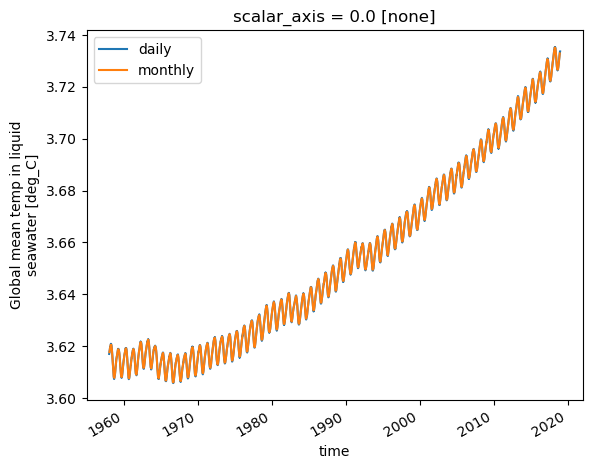

In [14]:
import matplotlib.pyplot as plt

ds_dict["ocean_scalar_snapshot.1day"]["temp_global_ave"].plot(label="daily")
ds_dict["ocean_scalar.1mon"]["temp_global_ave"].plot(label="monthly")

_ = plt.legend()

Subcatalogs can also be opened by accessing them directly as attribues or keys on the metacatalog.

(Note, the former only works if the catalog name comprises only letters, numbers and underscores)

In [15]:
subcat = metacat.HI_C_05_r1
subcat = metacat["HI_C_05_r1"]

Additional subcatalog metadata is stored in the `metadata` attribute of each subcatalog

In [16]:
subcat.metadata

{'contact': 'Tilo Ziehn',
 'created': None,
 'description': 'Historical run using same configuration as CMIP6 ACCESS-ESM1.5 historical r1i1p1f1,  but with nitrogen and phosphorus limitations disabled within CASA-CNP',
 'email': 'tilo.ziehn@csiro.au',
 'experiment_uuid': 'a8588f4d-4507-4832-ba94-9425e6f5b1b3',
 'keywords': (None,),
 'license': None,
 'long_description': 'Historical run using same configuration as CMIP6 ACCESS-ESM1.5 historical r1i1p1f1,  but with nitrogen and phosphorus limitations disabled within CASA-CNP. Branched from CMIP6 ACCESS-ESM1.5 piControl r1i1p1f1 in the year 161',
 'model': ('ACCESS-ESM1-5',),
 'name': 'HI_C_05_r1',
 'nominal_resolution': ('atmos = N96', 'ocean = 1 degree'),
 'notes': 'null',
 'parent_experiment': None,
 'reference': None,
 'related_experiments': ('ca37f09c-cde0-4f27-9148-8ed94721035d',
  '1b97f1c0-2bc4-4177-9acc-ce1f6cab5632',
  '1c6cb3ef-de8b-4a61-a1b6-e7044c07928f'),
 'url': None,
 'version': 1,
 'catalog_dir': ''}

## Another example workflow

Let's compare SST fields from three experiments:

- ACCESS-OM2, `1deg_jra55_iaf_omip2_cycle1`
- ACCESS-ESM1.5, `HI_C_05_r1`
- ACCESS-CM2, `bx944`

First we'll search directly for the experiments we're interested in and get the (intake-esm) subcatalogs for those experiments. Here we use the `to_source_dict` method to load the subcatalogs because there is more than one of them.

In [17]:
metacat4 = metacat.search(
    name=[
        "1deg_jra55_iaf_omip2_cycle1",
        "HI_C_05_r1",
        "bx944"
    ]
)

In [18]:
subcat_dict = metacat4.to_source_dict()

subcat_dict

{'HI_C_05_r1': <HI_C_05_r1 catalog with 11 dataset(s) from 7873 asset(s)>,
 'bx944': <bx944 catalog with 7 dataset(s) from 12150 asset(s)>,
 '1deg_jra55_iaf_omip2_cycle1': <1deg_jra55_iaf_omip2_cycle1 catalog with 11 dataset(s) from 2013 asset(s)>}

Now we'll search on monthly SST within each subcatalog and load each monthly SST dataset into an xarray Dataset

In [19]:
xarray_open_kwargs = dict(
    use_cftime=True,
)
xarray_combine_by_coords_kwargs = dict(
    compat="override",
    data_vars="minimal", 
    coords="minimal",
)
    
ds_dict = {
    name: subcat.search(
        realm="ocean",
        variable="sst",
        frequency="1mon"
    ).to_dask(
        xarray_open_kwargs=xarray_open_kwargs, 
        xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs
    )
    for name, subcat in subcat_dict.items()
}

Now we can plot our data

In [20]:
def plot_time(ds_dict, time):
    """ Plot monthly SST at a provided time """
    nrows = len(ds_dict)
    fig = plt.figure(figsize=(8, nrows*3))
    axs = fig.subplots(nrows,1)
    fig.suptitle(f'Monthly SST, {time}')
    
    for idx, (name, ds) in enumerate(ds_dict.items()):
        ax = axs[idx]
        if "member" in ds.dims:
            ds = ds.isel(member=0)
        data = ds["sst"].sel(time=time).compute()
        if (data > 273.15).any().item():
            data -= 273.15
        data.plot(ax=ax, cmap="viridis", vmin=-2, vmax=30)
        ax.set_title(name)
        ax.set_xlabel("")
        ax.set_ylabel("")
        
    fig.tight_layout()

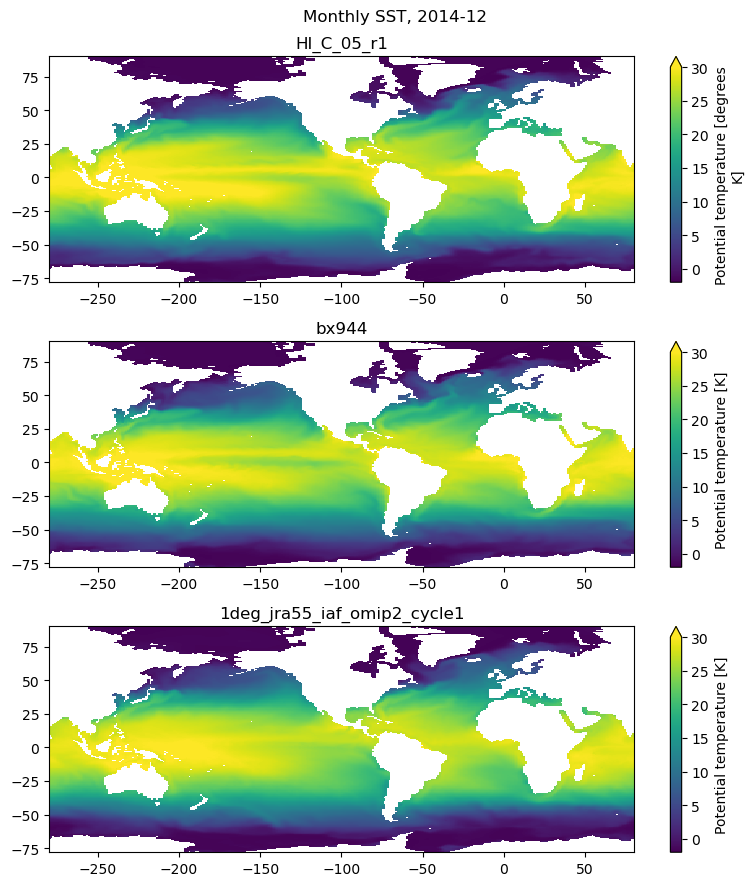

In [21]:
plot_time(ds_dict, time="2014-12")

Actually, I think I also want to add some CMIP6 data. That's easy because the NCI CMIP6 Intake catalogs are already included in our metacatalog (as are a bunch of other intake catalogs - have a browse and see).

In [22]:
cmip_subcat = metacat.search(name="cmip6_fs38").to_source()

In [23]:
ds = cmip_subcat.search(
    source_id="ACCESS-ESM1-5", 
    table_id="Omon", 
    variable_id="tos", 
    experiment_id="historical", 
    member_id="r1i1p1f1",
    file_type="f"
).to_dask()

ds_dict["CMIP6 ACCESS-ESM1.5 historical"] = ds.rename({"tos": "sst"})

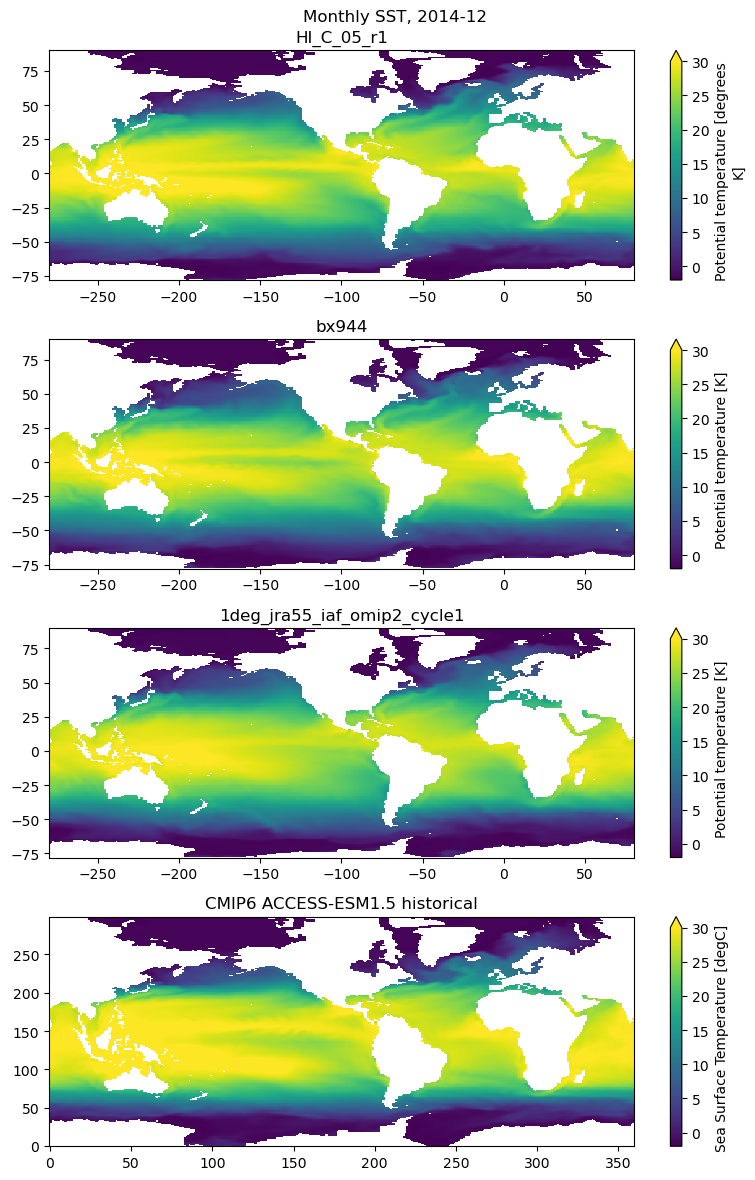

In [24]:
plot_time(ds_dict, time="2014-12")

In [25]:
client.close()